In [2]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import json

import skimage
import skimage.io, skimage.transform, skimage.filters

import importlib

In [3]:
def extract_words_from_dataset(jdata, acceptable_statuses):
    def process_words(words):
        return [(w['text'], w['filename']) for w in words if 'status' in w and w['status'] in acceptable_statuses]
    def process_lines(lines):
        res = [process_words(x['words']) for x in lines]
        return [x for y in res for x in y]
    res = [(process_lines(v['lines']), v['name']) for (k, v) in jdata.items()]
    return [(x[0], name+'/'+x[1]) for (y, name) in res for x in y]

def downscale_x(img, scale):
    if scale > 1.0:
        raise Exception("downscale: scale must be <= 1.0")
    if scale == 1.0:
        return img
    tmp = skimage.transform.rescale(img, (1.0, scale), mode='constant', cval=1.0)
    diff = img.shape[1] - tmp.shape[1]
    d1 = diff // 2
    d2 = diff - d1
    return np.hstack([np.ones((tmp.shape[0], d1)), tmp,np.ones((tmp.shape[0], d2))])

def downscale_y(img, scale):
    if scale > 1.0:
        raise Exception("downscale: scale must be <= 1.0")
    if scale == 1.0:
        return img
    tmp = skimage.transform.rescale(img, (scale, 1.0), mode='constant', cval=1.0)
    diff = img.shape[0] - tmp.shape[0]
    d1 = diff // 2
    d2 = diff - d1
    return np.vstack([np.ones((d1, tmp.shape[1])), tmp,np.ones((d2, tmp.shape[1]))])

def upscale_x(img, scale):
    if scale < 1.0:
        raise Exception("uscale: scale must be >= 1.0")
    if scale == 1.0:
        return img
    tmp = skimage.transform.rescale(img, (1.0, scale), mode='constant', cval=1.0)
    diff = tmp.shape[1]-img.shape[1]
    d0 = diff // 2
    return tmp[:, d0:(img.shape[1]+d0)]


def upscale_y(img, scale):
    if scale < 1.0:
        raise Exception("uscale: scale must be >= 1.0")
    if scale == 1.0:
        return img
    tmp = skimage.transform.rescale(img, (scale, 1.0), mode='constant', cval=1.0)
    diff = tmp.shape[0]-img.shape[0]
    d0 = diff // 2
    return tmp[d0:(img.shape[0]+d0), :]

def rescale(img, scale):
    xs = scale
    ys = scale
    if type(scale) in (list, tuple):
        xs = scale[0]
        ys = scale[1]
    xfn = downscale_x if xs < 1.0 else upscale_x
    yfn = downscale_y if ys < 1.0 else upscale_y
    return yfn(xfn(img, xs), ys)

def trim_image_width(img):
    tmp = np.max(img, axis=0)>0
    id1 = np.argmax(tmp)
    id2 = len(tmp) - np.argmax(tmp[::-1])
    return img[:, id1:id2]

def trim_image_height(img):
    tmp = np.max(img, axis=1)>0
    id1 = np.argmax(tmp)
    id2 = len(tmp) - np.argmax(tmp[::-1])
    return img[id1:id2, :]

def perform_transform(img, transform):
    if type(transform) == list:
        res = img
        for t in transform:
            res = perform_transform(res, t)
        return res
    if type(transform) != dict:
        raise Exception("perform_transform() expected parameter 'transform' to be dict!")
    if 'type' not in transform:
        raise Exception("perform_transform() parameter 'transform' should have valid 'type' value!")
    if transform['type'] == 'rotate':
        return skimage.transform.rotate(img, transform.get('angle', 0), mode='constant', cval=1.0)
    if transform['type'] == 'shift':
        inv_map = np.array([[1,0,-transform.get('x', 0)*img.shape[0]],
                              [0,1,-transform.get('y', 0)*img.shape[0]],
                              [0,0,1]])
        return skimage.transform.warp(img, inv_map, mode='constant', cval=1.0)
    if transform['type'] == 'cutoff':
        return 1.0*(img < transform.get('cutoff', 0.5))
    if transform['type'] == 'scale':
        return rescale(img, (transform.get('x', 1.0), transform.get('y', 1.0)))
    if transform['type'] == 'resize':
        xs = transform.get('x', None)
        ys = transform.get('y', None)
        if xs is None and ys is None:
            raise Exception("perform_transform() parameter 'transform' should have at least one x or y for resize!")
        if xs is None:
            xs = int(ys / img.shape[0] * img.shape[1])
        if ys is None:
            ys = int(xs / img.shape[1] * img.shape[0])
        return skimage.transform.resize(img, (ys, xs), mode='constant', cval=1.0)
    if transform['type'] == 'trimx':
        return trim_image_width(img)
    if transform['type'] == 'trimy':
        return trim_image_height(img)
    
def generate_rotations(min_angle, max_angle, num):
    return [{'type':'rotate', 'angle':x} for x in np.linspace(min_angle, max_angle, num)]

def generate_scales(min_scale, max_scale, num):
    return [{'type':'scale', 'x':x, 'y':y}
        for x in np.linspace(min_scale, max_scale, num)
        for y in np.linspace(min_scale, max_scale, num)]

def generate_shifts(min_shift, max_shift, num):
    return [{'type':'shift', 'x':x, 'y':y}
        for x in np.linspace(min_shift, max_shift, num)
        for y in np.linspace(min_shift, max_shift, num)]

def generate_cutoffs(min_cutoff, max_cutoff, num):
    return [{'type':'cutoff', 'cutoff':x} for x in np.linspace(min_cutoff, max_cutoff, num)]


def generate_combinations2(transform_set1, transform_set2):
    return [(x if type(x) == list else [x]) + (y if type(y) == list else [y])
        for x in transform_set1 for y in transform_set2]

def generate_combinations(*sets):
    if len(sets) == 1:
        return sets[0]
    if len(sets) == 2:
        return generate_combinations2(sets[0], sets[1])
    args = [generate_combinations2(sets[0], sets[1])] + list(sets[2:])
    return generate_combinations(*args)

def append_transformations(transform_sets, pre_transforms=[], post_transforms=[]):
    return [pre_transforms + (x if type(x) == list else [x]) + post_transforms
            for x in transform_sets]

In [4]:
extraction_path = os.path.join(os.path.dirname(cfg.words_path),
                               os.path.basename(cfg.words_path).split('.')[0])
with open(cfg.words_path, 'r', encoding='utf-8') as f:
    src = json.load(f)
    
words = extract_words_from_dataset(src, (1,))

In [5]:
tmp = skimage.io.imread(os.path.join(extraction_path, words[2][1]), as_grey=True)

IndexError: list index out of range

In [6]:
skimage.io.imshow(tmp)

NameError: name 'tmp' is not defined

In [38]:
transforms_rotation = generate_rotations(-10, 10, 5)
transforms_scale = generate_scales(0.75, 1.25, 3)
transforms_shift = generate_shifts(-0.1, 0.1, 3)
transforms_cutoff = generate_cutoffs(0.25, 0.50, 5)
combinations_all = generate_combinations(transforms_rotation, transforms_shift,
                                       transforms_scale, transforms_cutoff)

fixed_post = [{'type':'resize', 'y':64},{'type':'trimx'}]
transforms_all = append_transformations(combinations_all, post_transforms=fixed_post)

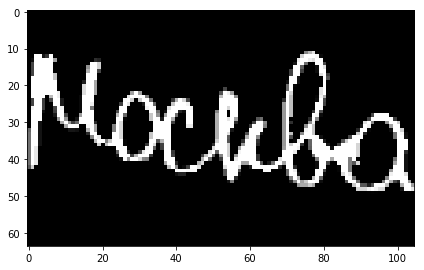

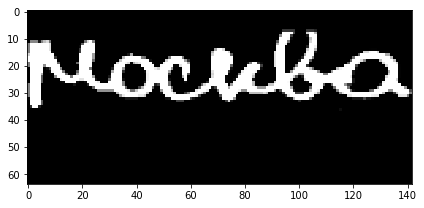

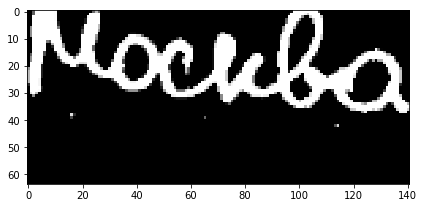

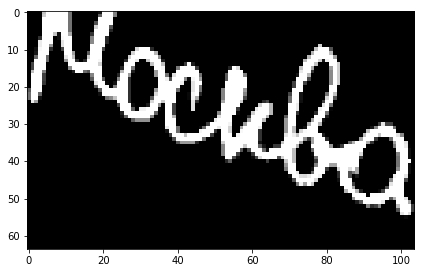

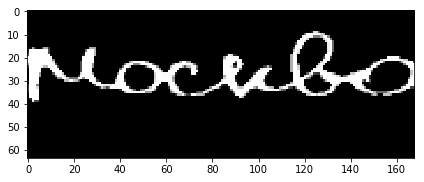

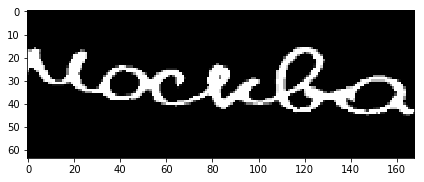

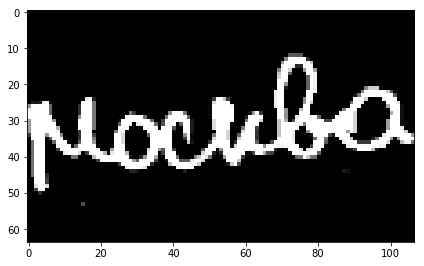

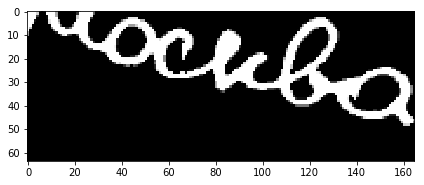

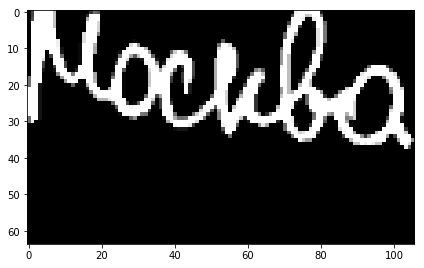

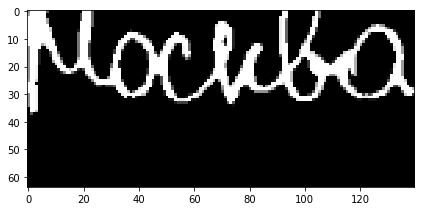

In [55]:
for t in np.random.choice(np.arange(len(transforms_all)), size=10):
    skimage.io.imshow(perform_transform(tmp, transforms_all[t]))
    plt.show()

In [48]:
np.random.choice(transforms_all)

ValueError: a must be 1-dimensional